In [ ]:

# # Business Intelligence Lab 4: Text Mining & NLP  
# ## Star Wars Original Trilogy Script Analysis  
# Lab Tasks:
# 1. Find characters with the most dialogues in each episode (IV, V, VI).  
# 2. Plot the number of dialogues per top character for each episode.  
# 3. Add an “episode” column and concatenate the three datasets.  
# 4. Discover frequency distribution of words in the entire trilogy (raw text).  
# 5. Create a frequency distribution plot of the most repeated raw words.  
# 6. Perform text‐mining preprocessing (lowercase, tokenize, stopword removal, lemmatization) and add a `new_script` column.  
# 7. Repeat frequency distribution (and plot) on the cleaned `new_script`.  
# 8. Generate Word Clouds for Darth Vader and Yoda using provided masks.  
# 9. Discover most relevant words via TF‐IDF.  
# 10. Perform sentiment analysis on all dialogues, comparing Dark Side vs. Light Side.  


## Output_Summary:
# The Star Wars trilogy dialogue dataset includes 2,523 lines across Episodes IV–VI, with Episode IV having the most (1,010). 
# Top characters by dialogue count include LUKE, HAN, and THREEPIO, while sentiment analysis shows Light Side characters speak more positively than Dark Side ones. 
# TF-IDF highlights key words like “luke,” “come,” and “going,” revealing thematic focus, while Vader and Luke represent the emotional extremes in dialogue.




In [ ]:
# ## Step 1: Import Libraries and Configure NLTK

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import TfidfVectorizer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sns.set_style('whitegrid')
%matplotlib inline

# Download NLTK resources (run once)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Initialize tokenizer, lemmatizer, and stopword set
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


In [ ]:
## Step 2: Define a Function to Load and Parse Each Script File  
# Each line in the `.txt` files is formatted as:  
# `"line_number" "CHARACTER" "Dialogue text..."`  
# The header line is `"character" "dialogue"`, but data lines have three quoted fields.  

# I will:
         # - Skip the header.
         # - Split each subsequent line on `'" "'`.
         # - Extract `line_number` (ignored later), `character`, and `dialogue`.
         # - Add an `episode` column.

def load_script(filepath: str, episode_name: str) -> pd.DataFrame:
    """
    Reads a Star Wars script text file where each data line is:
      "line_number" "CHARACTER" "Dialogue..."
    Returns a DataFrame with columns: ['line', 'character', 'dialogue', 'episode'].
    """
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    # Skip header line
    for raw_line in lines[1:]:
        line = raw_line.strip()
        if not line:
            continue
        # Split on '" "' then strip extra quotes
        parts = line.split('" "')
        parts = [p.strip('"') for p in parts]
        if len(parts) >= 3:
            line_num = parts[0]
            character = parts[1].strip()
            dialogue = '" "'.join(parts[2:]).strip()
            data.append([line_num, character, dialogue, episode_name])
    df = pd.DataFrame(data, columns=['line', 'character', 'dialogue', 'episode'])
    return df

In [ ]:
## Step 3: Load All Three Episodes and Concatenate  

# File paths for Episodes IV, V, VI
episode_files = {
    'Episode IV':  r"C:\Users\niral\OneDrive\Desktop\BI\Lab-4\Lab4_dataset\star_wars_movies_scripts\SW_EpisodeIV.txt",
    'Episode V':   r"C:\Users\niral\OneDrive\Desktop\BI\Lab-4\Lab4_dataset\star_wars_movies_scripts\SW_EpisodeV.txt",
    'Episode VI':  r"C:\Users\niral\OneDrive\Desktop\BI\Lab-4\Lab4_dataset\star_wars_movies_scripts\SW_EpisodeVI.txt"
}

# Parse and load each episode
dfs = []
for ep_name, path in episode_files.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f"Cannot find script file: {path}")
    df_ep = load_script(path, ep_name)
    print(f"{ep_name}: Parsed {len(df_ep)} dialogues")
    dfs.append(df_ep)

# Concatenate all episodes into one DataFrame
combined_df = pd.concat(dfs, ignore_index=True)
print(f"\nCombined dataset total rows: {len(combined_df)}")
combined_df.head(3)


Episode IV: Parsed 1010 dialogues
Episode V: Parsed 839 dialogues
Episode VI: Parsed 674 dialogues

Combined dataset total rows: 2523


,line,character,dialogue,episode
0,1,THREEPIO,Did you hear that? They've shut down the main...,Episode IV
1,2,THREEPIO,We're doomed!,Episode IV
2,3,THREEPIO,There'll be no escape for the Princess this time.,Episode IV


In [ ]:
## Step 4: Task 1 – Find Characters with the Most Dialogues in Each Episode  
# I will normalize character names to uppercase, count dialogues, and print the top 10 per episode.

for ep in combined_df['episode'].unique():
    ep_df = combined_df[combined_df['episode'] == ep].copy()
    ep_df['character_norm'] = ep_df['character'].str.upper().str.strip()
    counts = ep_df['character_norm'].value_counts().head(10)
    
    print(f"\nTop 10 Characters in {ep}:")
    print(counts)



Top 10 Characters in Episode IV:
character_norm
LUKE          254
HAN           153
THREEPIO      119
BEN            82
LEIA           57
VADER          41
RED LEADER     37
BIGGS          34
TARKIN         28
OWEN           25
Name: count, dtype: int64

Top 10 Characters in Episode V:
character_norm
HAN         182
LUKE        128
LEIA        114
THREEPIO     92
LANDO        61
VADER        56
YODA         36
PIETT        23
CREATURE     21
BEN          15
Name: count, dtype: int64

Top 10 Characters in Episode VI:
character_norm
HAN         124
LUKE        112
THREEPIO     90
LEIA         56
VADER        43
LANDO        40
EMPEROR      39
JABBA        20
BEN          18
ACKBAR       14
Name: count, dtype: int64


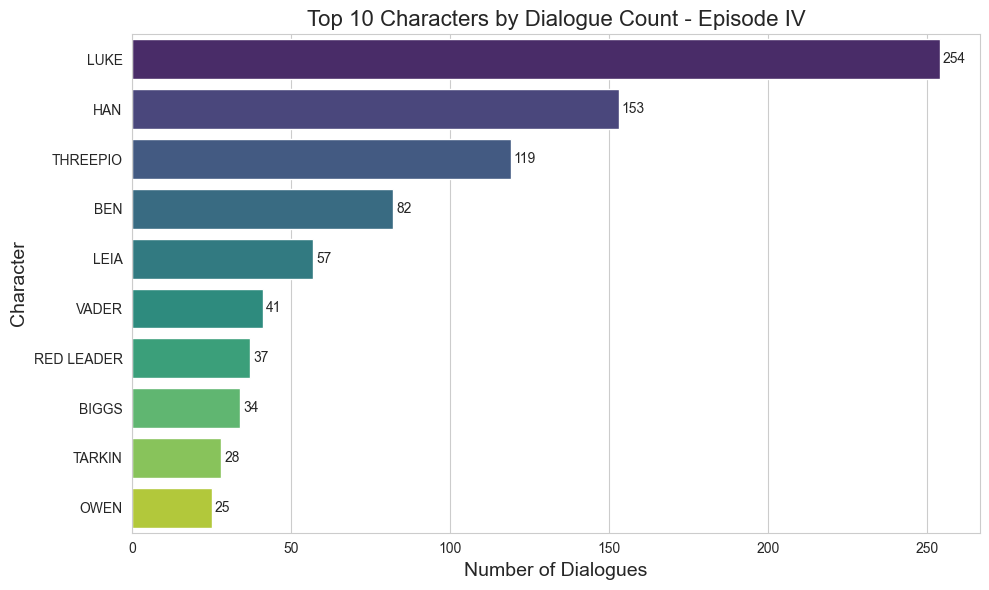

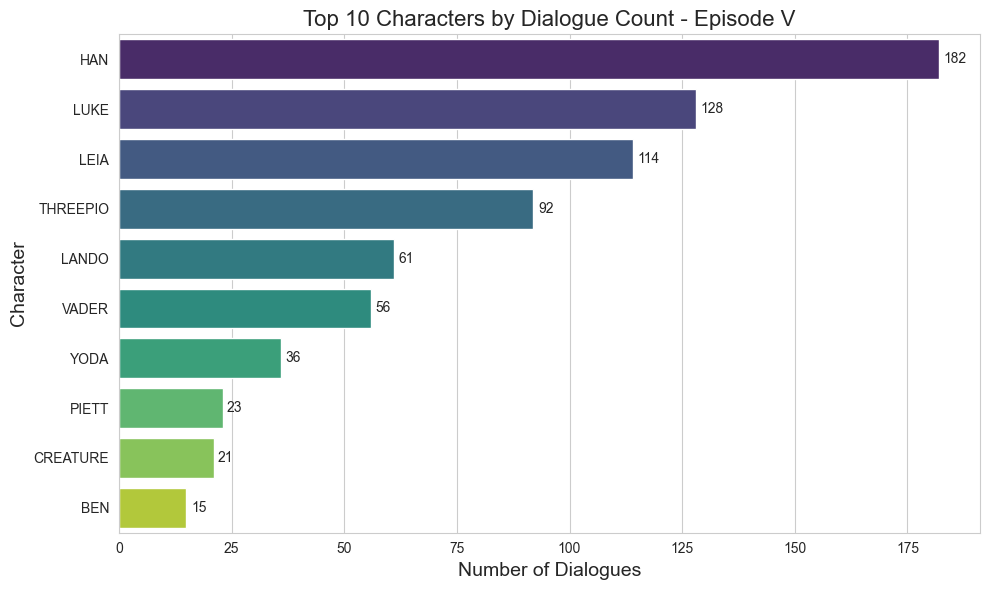

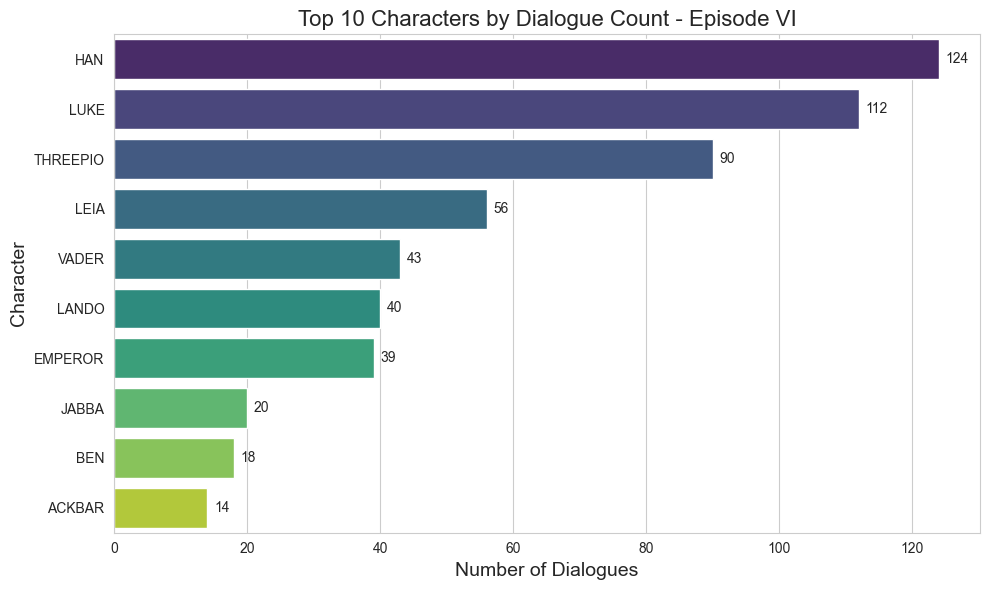

In [ ]:
## Step 5: Task 2 – Plot Number of Dialogues per Top Character for Each Episode  
# Using the counts from Step 4, plot bar charts for each episode.

for ep in combined_df['episode'].unique():
    ep_df = combined_df[combined_df['episode'] == ep]
    ep_df['character_norm'] = ep_df['character'].str.upper().str.strip()
    counts = ep_df['character_norm'].value_counts().head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts.values, y=counts.index, palette='viridis')
    plt.title(f"Top 10 Characters by Dialogue Count - {ep}", fontsize=16)
    plt.xlabel("Number of Dialogues", fontsize=14)
    plt.ylabel("Character", fontsize=14)
    for i, v in enumerate(counts.values):
        plt.text(v + 1, i, str(v), va='center')
    plt.tight_layout()
    plt.show()


In [ ]:
## Step 6: Task 4 – Frequency Distribution of Raw Words (All Episodes Combined)  
# 1. Concatenate all dialogues into one large lowercase string.  
# 2. Tokenize into words (using `RegexpTokenizer`).  
# 3. Compute frequency distribution.

# Concatenate all dialogues
all_dialogues_raw = combined_df['dialogue'].str.cat(sep=' ').lower()

# Tokenize (words only, no punctuation)
all_words_raw = RegexpTokenizer(r'\w+').tokenize(all_dialogues_raw)

print(f"Total raw tokens: {len(all_words_raw)}")

# Frequency distribution
freq_dist_raw = FreqDist(all_words_raw)
print("\nTop 20 Most Common Words (Raw):")
print(freq_dist_raw.most_common(20))


Total raw tokens: 27463

Top 20 Most Common Words (Raw):
[('you', 1056), ('i', 985), ('the', 917), ('to', 646), ('it', 461), ('a', 440), ('s', 435), ('t', 393), ('of', 351), ('we', 305), ('your', 288), ('that', 285), ('is', 274), ('this', 249), ('be', 246), ('and', 246), ('in', 244), ('on', 230), ('he', 219), ('me', 216)]


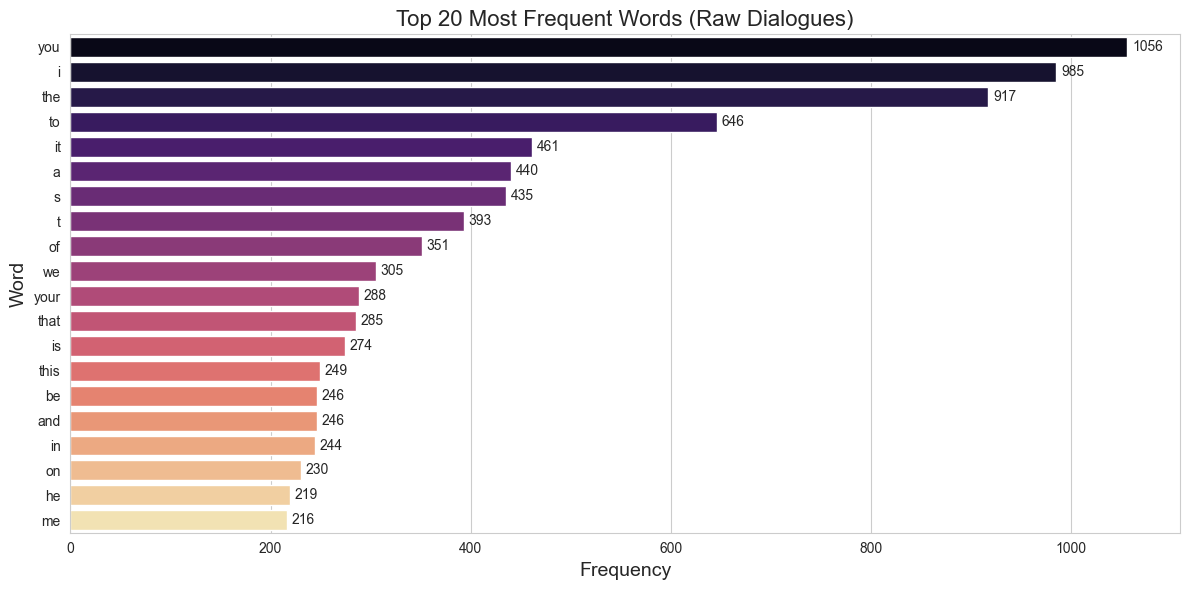

In [ ]:
## Step 7: Task 5 – Plot Frequency Distribution of Top Raw Words  
# Plot the top 20 most frequent raw words from Step 6.

# Get top 20 raw words
top_raw = freq_dist_raw.most_common(20)
words_raw = [w[0] for w in top_raw]
counts_raw = [w[1] for w in top_raw]

plt.figure(figsize=(12, 6))
sns.barplot(x=counts_raw, y=words_raw, palette='magma')
plt.title("Top 20 Most Frequent Words (Raw Dialogues)", fontsize=16)
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Word", fontsize=14)
for i, v in enumerate(counts_raw):
    plt.text(v + 5, i, str(v), va='center')
plt.tight_layout()
plt.show()


In [ ]:
## Step 8: Task 6 – Text-Mining Preprocessing and Add `new_script` Column  
# 6a. Clean each dialogue by:  
#   - Lowercasing  
#   - Tokenizing to words  
#   - Removing stopwords  
#   - Lemmatizing  
# 6b. Store the cleaned token list in a new column `new_script`.

def clean_text(text: str) -> list[str]:
    """
    Lowercase, tokenize, remove English stopwords, lemmatize.
    Returns a list of cleaned tokens.
    """
    if not isinstance(text, str) or not text.strip():
        return []
    tokens = tokenizer.tokenize(text.lower())
    filtered = [t for t in tokens if t not in stop_words]
    lemmatized = [lemmatizer.lemmatize(t) for t in filtered]
    return lemmatized

# Apply cleaning to every dialogue
combined_df['new_script'] = combined_df['dialogue'].apply(clean_text)

# Show sample
combined_df[['dialogue', 'new_script']].head(3)


,dialogue,new_script
0,Did you hear that? They've shut down the main...,"[hear, shut, main, reactor, destroyed, sure, m..."
1,We're doomed!,[doomed]
2,There'll be no escape for the Princess this time.,"[escape, princess, time]"


Total cleaned tokens: 12395

Top 20 Most Common Words (Cleaned):
[('luke', 137), ('get', 130), ('going', 121), ('come', 113), ('right', 113), ('oh', 113), ('know', 111), ('see', 95), ('well', 92), ('sir', 91), ('go', 89), ('artoo', 85), ('one', 84), ('u', 83), ('good', 80), ('got', 78), ('yes', 78), ('take', 75), ('ship', 74), ('back', 73)]


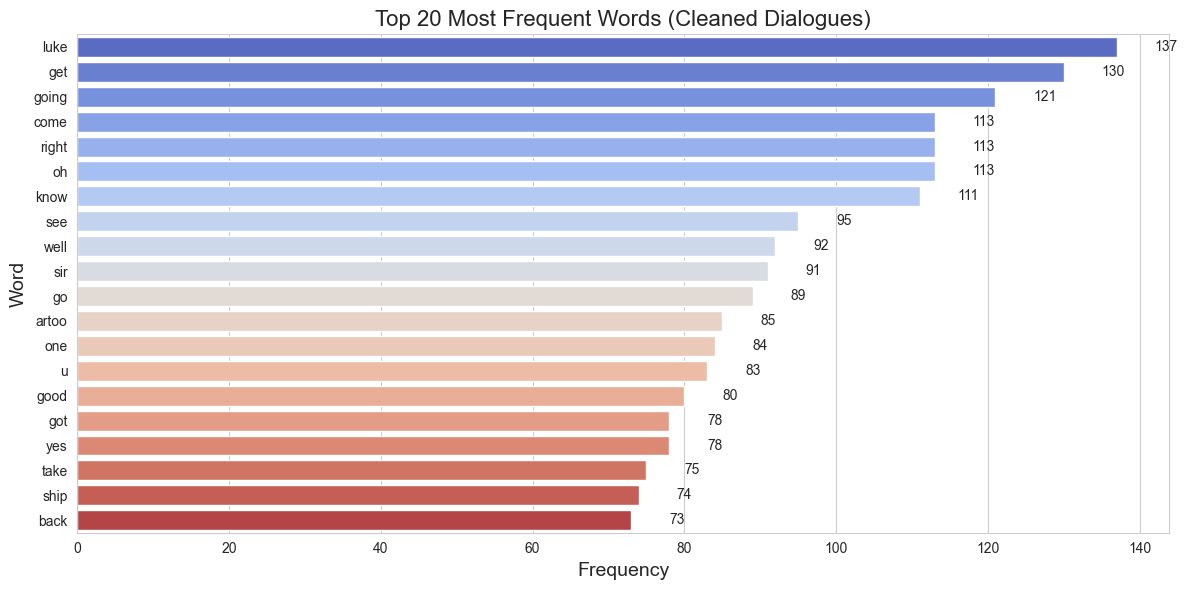

In [ ]:
## Step 9: Task 7 – Frequency Distribution on Cleaned Text & Plot  
# 7a. Flatten all tokens in `new_script` and recompute frequency distribution.  
# 7b. Plot the top 20 most frequent cleaned words.

# Flatten cleaned tokens into one list
all_words_clean = [token for sublist in combined_df['new_script'] for token in sublist]
print(f"Total cleaned tokens: {len(all_words_clean)}")

# Frequency distribution on cleaned tokens
freq_dist_clean = FreqDist(all_words_clean)
print("\nTop 20 Most Common Words (Cleaned):")
print(freq_dist_clean.most_common(20))

# Plot top 20 cleaned words
top_clean = freq_dist_clean.most_common(20)
words_clean = [w[0] for w in top_clean]
counts_clean = [w[1] for w in top_clean]

plt.figure(figsize=(12, 6))
sns.barplot(x=counts_clean, y=words_clean, palette='coolwarm')
plt.title("Top 20 Most Frequent Words (Cleaned Dialogues)", fontsize=16)
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Word", fontsize=14)
for i, v in enumerate(counts_clean):
    plt.text(v + 5, i, str(v), va='center')
plt.tight_layout()
plt.show()


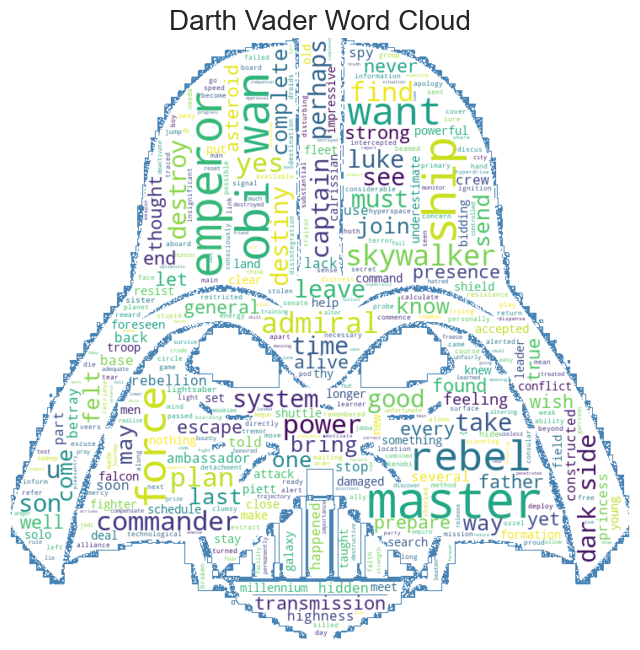

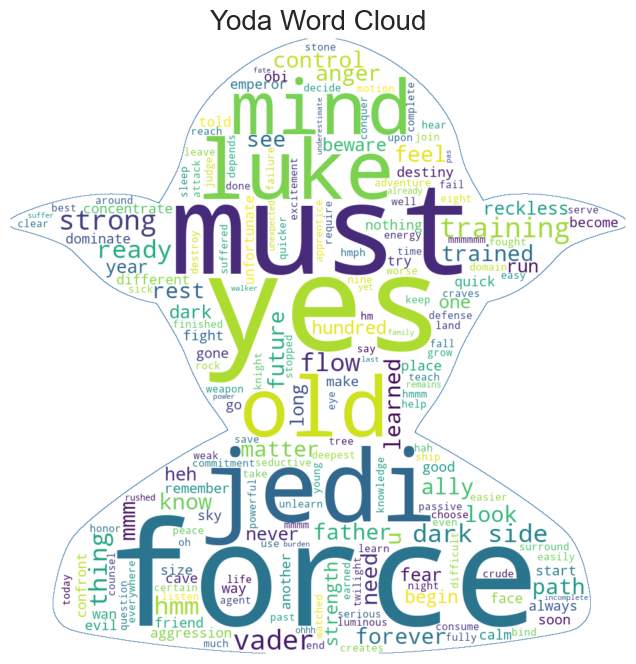

In [ ]:
## Step 10: Task 8 – Word Clouds for Darth Vader and Yoda  
# 1. Using masks `vader.jpg` and `yoda.png`.  
# 2. Filter `combined_df` for any character containing “VADER” (case-insensitive) and “YODA”.  
# 3. Concatenate dialogues, clean with `clean_text()`, and re-join as a string.  
# 4. Generate and plot a WordCloud for each.

# Paths to mask images (raw strings)
vader_mask_path = r"C:\Users\niral\OneDrive\Desktop\BI\Lab-4\Lab4_dataset\wordcloud_masks\vader.jpg"
yoda_mask_path  = r"C:\Users\niral\OneDrive\Desktop\BI\Lab-4\Lab4_dataset\wordcloud_masks\yoda.png"

# Verify masks exist
for path in (vader_mask_path, yoda_mask_path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Mask file not found: {path}")

# Load masks as numpy arrays
vader_mask = np.array(Image.open(vader_mask_path))
yoda_mask  = np.array(Image.open(yoda_mask_path))

# Helper function to get cleaned text string for a given character pattern
def get_cleaned_text_for(character_pattern: str) -> str:
    filtered = combined_df[combined_df['character'].str.contains(character_pattern, case=False, na=False)]
    concatenated = filtered['dialogue'].str.cat(sep=' ')
    tokens = clean_text(concatenated)
    return " ".join(tokens)

# Generate and plot Darth Vader word cloud
vader_text = get_cleaned_text_for("VADER")
if vader_text.strip():
    wc_vader = WordCloud(
        background_color='white',
        max_words=1000,
        mask=vader_mask,
        contour_width=1,
        contour_color='steelblue'
    ).generate(vader_text)

    plt.figure(figsize=(8,8))
    plt.imshow(wc_vader, interpolation='bilinear')
    plt.axis('off')
    plt.title("Darth Vader Word Cloud", fontsize=20)
    plt.show()
else:
    print("No Darth Vader dialogues found.")

# Generate and plot Yoda word cloud
yoda_text = get_cleaned_text_for("YODA")
if yoda_text.strip():
    wc_yoda = WordCloud(
        background_color='white',
        max_words=1000,
        mask=yoda_mask,
        contour_width=1,
        contour_color='steelblue'
    ).generate(yoda_text)

    plt.figure(figsize=(8,8))
    plt.imshow(wc_yoda, interpolation='bilinear')
    plt.axis('off')
    plt.title("Yoda Word Cloud", fontsize=20)
    plt.show()
else:
    print("No Yoda dialogues found.")


In [ ]:
## Step 11: Task 9 – TF‐IDF Analysis for Most Relevant Words  
# 1. Treat each dialogue’s `new_script` tokens as a “document” by joining them into a string.  
# 2. Fit `TfidfVectorizer` on all cleaned dialogues.  
# 3. Compute average TF‐IDF score per word across all dialogues.  
# 4. Display the top 20 words by TF‐IDF score.

# Convert each dialogue’s cleaned tokens back into a single string
combined_df['cleaned_str'] = combined_df['new_script'].apply(lambda tokens: " ".join(tokens))

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf.fit_transform(combined_df['cleaned_str'])
feature_names = tfidf.get_feature_names_out()

# Average TF-IDF score per feature across all dialogues
avg_scores = tfidf_matrix.mean(axis=0).A1
tfidf_df = pd.DataFrame({'word': feature_names, 'tfidf_score': avg_scores})
tfidf_df = tfidf_df.sort_values(by='tfidf_score', ascending=False).reset_index(drop=True)

print("Top 20 Most Relevant Words (TF-IDF):")
print(tfidf_df.head(20))



Top 20 Most Relevant Words (TF-IDF):
      word  tfidf_score
0     luke     0.019874
1     come     0.018871
2    going     0.018453
3    right     0.018196
4      get     0.017643
5       oh     0.017516
6      yes     0.016343
7     know     0.016261
8      sir     0.015191
9      see     0.014821
10      go     0.014614
11   artoo     0.013711
12  chewie     0.012759
13    well     0.012361
14     got     0.011598
15    good     0.011238
16     one     0.010945
17    back     0.010382
18    look     0.010262
19    take     0.010252



Dark Side dialogues count:  168
Light Side dialogues count: 1231


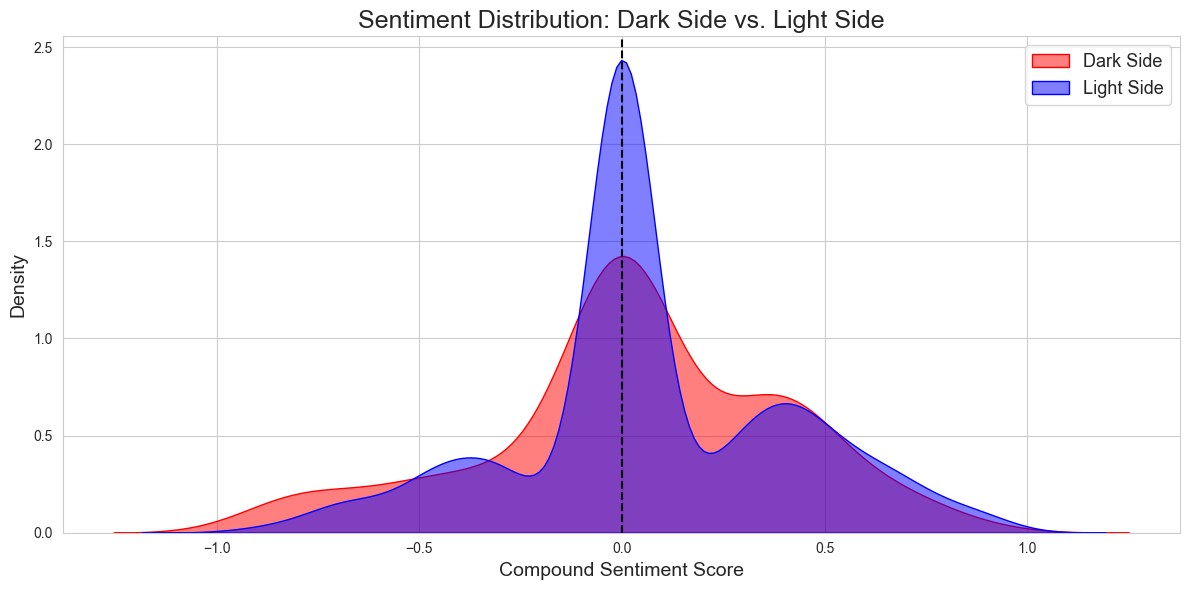


Average Sentiment Scores:
Dark Side:  0.0330
Light Side: 0.0718
Difference (Light – Dark): 0.0388

Sample Dark Side dialogues (most negative):
character                                                                                                                                              dialogue  compound_sentiment
    VADER Don't be too proud of this technological terror you've constructed.  The ability to destroy a planet is insignificant next to the power of the Force.             -0.8609
    VADER                                                     Leave that to me.  Send a distress signal and then inform the senate that all aboard were killed!             -0.8516
   TARKIN             The regional governors now have direct control over territories.  Fear will keep the local systems in line.  Fear of this battle station.             -0.8402

Sample Light Side dialogues (most positive):
character                                                                                 

In [ ]:
# ## Step 12: Task 10 – Sentiment Analysis on All Dialogues  
# 1. Use VADER to compute compound sentiment score on each raw `dialogue`.  
# 2. Add these scores in a column `compound_sentiment`.  
# 3. Define Dark Side vs. Light Side characters and compare their sentiment distributions.

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Compute sentiment for each dialogue
combined_df['sentiment_dict'] = combined_df['dialogue'].apply(lambda txt: sia.polarity_scores(txt))
combined_df['compound_sentiment'] = combined_df['sentiment_dict'].apply(lambda d: d['compound'])

# Show sample
combined_df[['character', 'dialogue', 'compound_sentiment']].head(5)

# Define Dark Side and Light Side keywords
dark_keywords  = ['VADER', 'PALPATINE', 'DARTH', 'TARKIN']
light_keywords = ['YODA', 'LUKE', 'OBI-WAN', 'LEIA', 'HAN', 'CHEWBACCA', 'OBIWAN']

# Filter Dark Side dialogues
dark_df = combined_df[combined_df['character'].str.contains('|'.join(dark_keywords), case=False, na=False)]

# Filter Light Side dialogues
light_df = combined_df[combined_df['character'].str.contains('|'.join(light_keywords), case=False, na=False)]

print(f"\nDark Side dialogues count:  {len(dark_df)}")
print(f"Light Side dialogues count: {len(light_df)}")

# Plot sentiment distributions
plt.figure(figsize=(12, 6))
sns.kdeplot(dark_df['compound_sentiment'], fill=True, color='red', alpha=0.5, label='Dark Side')
sns.kdeplot(light_df['compound_sentiment'], fill=True, color='blue', alpha=0.5, label='Light Side')
plt.axvline(0, color='black', linestyle='--')
plt.title("Sentiment Distribution: Dark Side vs. Light Side", fontsize=18)
plt.xlabel("Compound Sentiment Score", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

# Print average sentiment scores
dark_mean = dark_df['compound_sentiment'].mean() if not dark_df.empty else 0.0
light_mean = light_df['compound_sentiment'].mean() if not light_df.empty else 0.0
print(f"\nAverage Sentiment Scores:")
print(f"Dark Side:  {dark_mean:.4f}")
print(f"Light Side: {light_mean:.4f}")
print(f"Difference (Light – Dark): {(light_mean - dark_mean):.4f}")

# Sample most negative Dark Side dialogues
if not dark_df.empty:
    print("\nSample Dark Side dialogues (most negative):")
    print(dark_df.nsmallest(3, 'compound_sentiment')[['character', 'dialogue', 'compound_sentiment']].to_string(index=False))
else:
    print("\nNo Dark Side dialogues to sample.")

# Sample most positive Light Side dialogues
if not light_df.empty:
    print("\nSample Light Side dialogues (most positive):")
    print(light_df.nlargest(3, 'compound_sentiment')[['character', 'dialogue', 'compound_sentiment']].to_string(index=False))
else:
    print("\nNo Light Side dialogues to sample.")
